<a href="https://colab.research.google.com/github/StefanHubner/MachineLearningEconomics/blob/main/Logit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages("ISLR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(ISLR)

data("Default")
Default$default1 <- as.double(Default$default == "Yes")

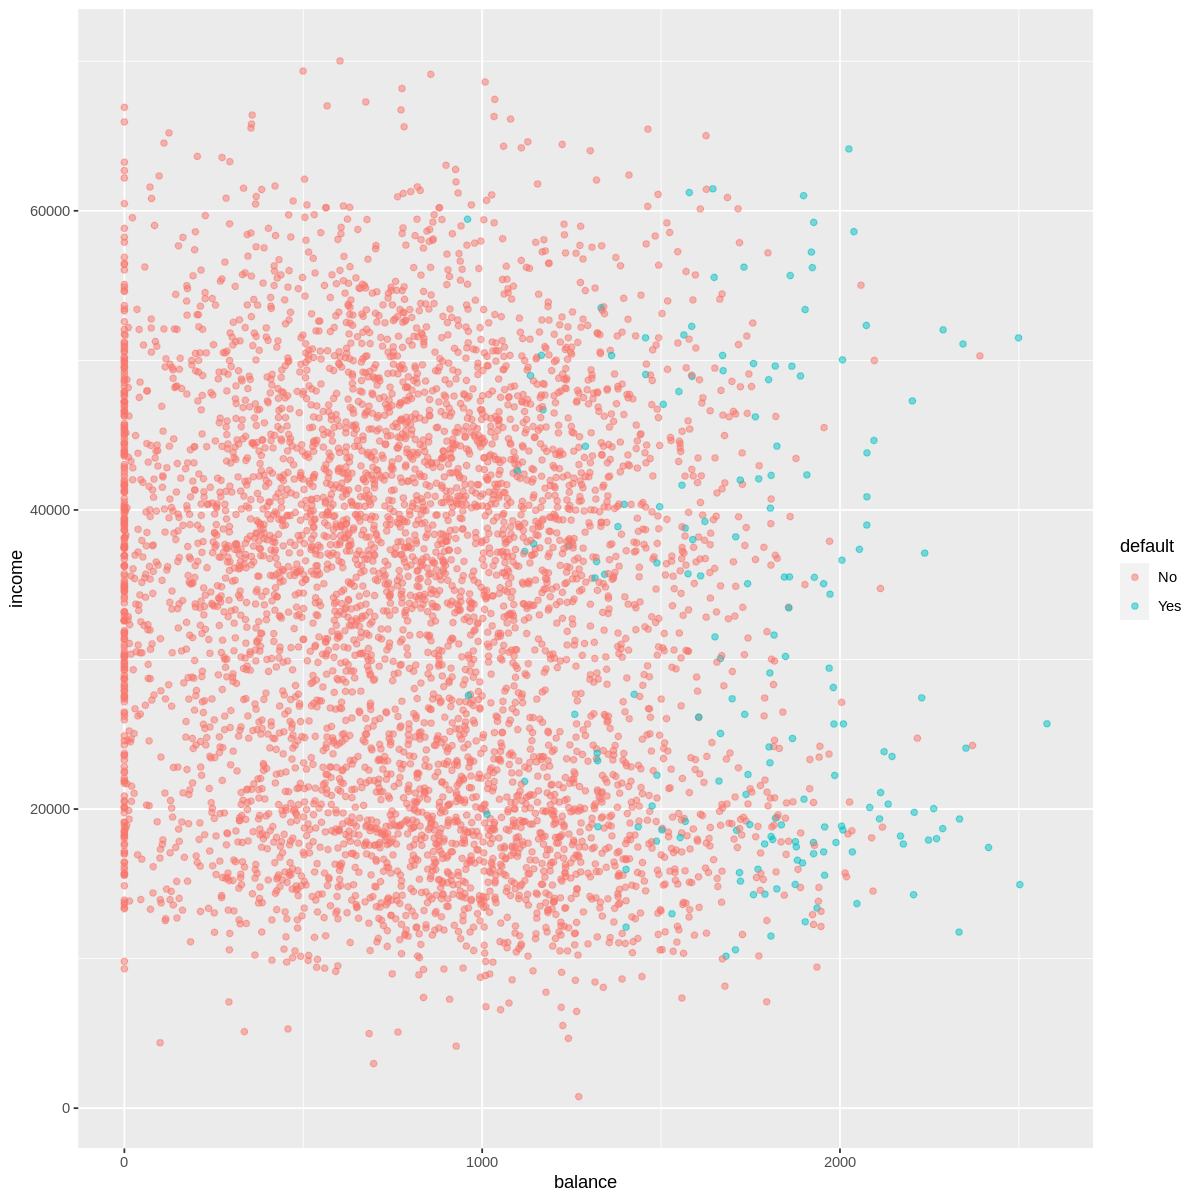

In [4]:
library(ggplot2)

options(repr.plot.width = 10, repr.plot.height = 10)

n <- nrow(Default)
traini <- sample(1:n, n/2)
testi <- -traini

p0 <- ggplot(Default[testi,], aes(y = income, x = balance, color = default)) +
        geom_point(alpha = 0.5)

p0

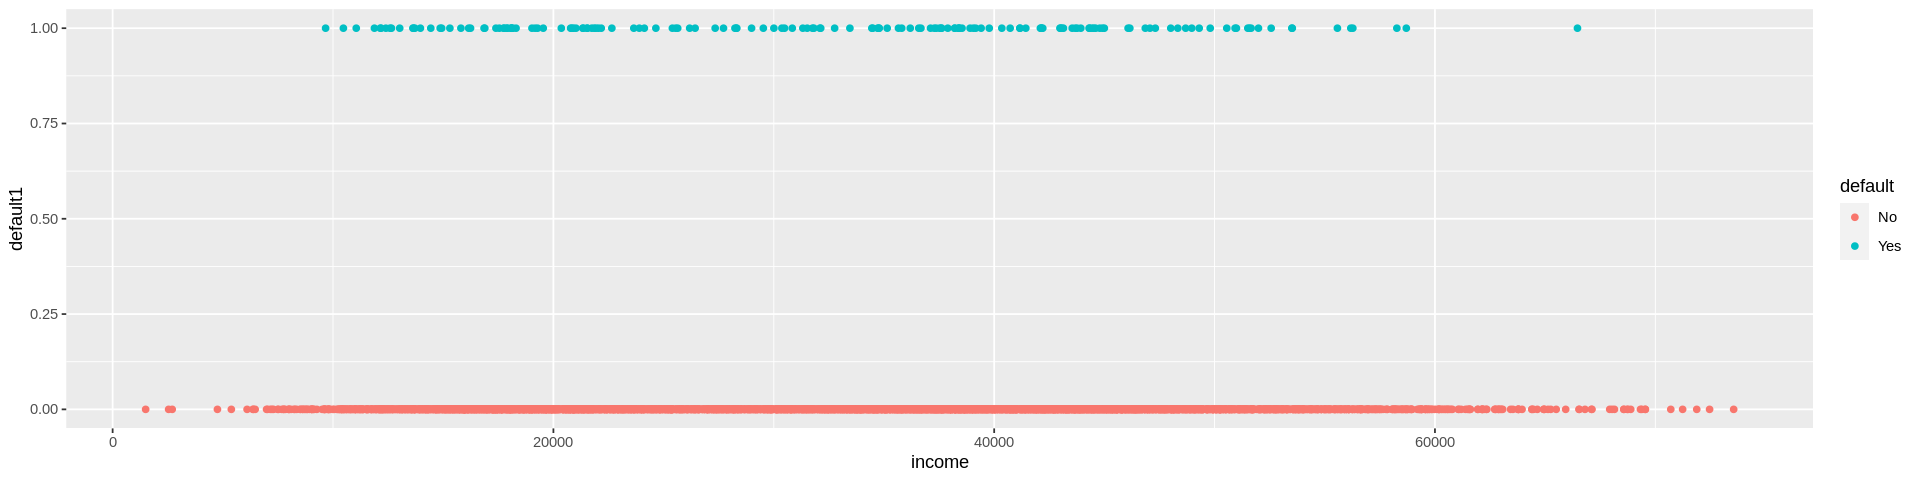

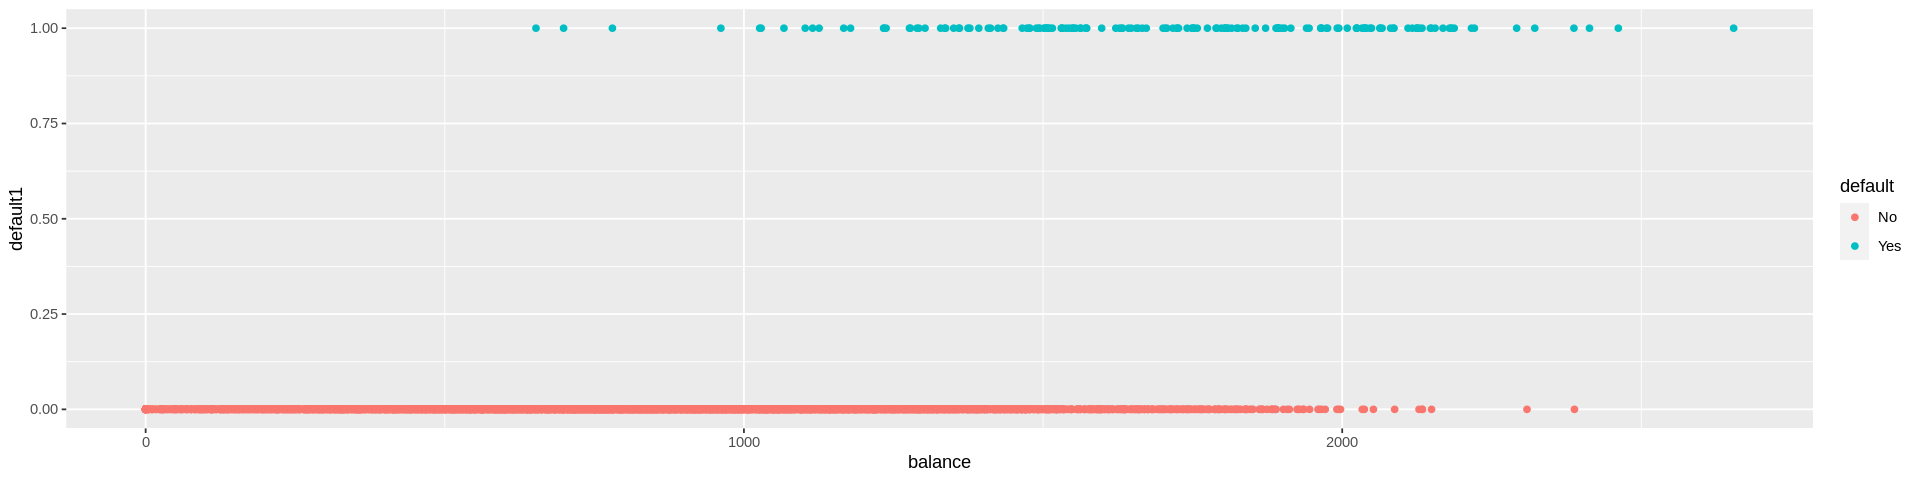

In [5]:
options(repr.plot.width = 16, repr.plot.height = 4)

p1 <- ggplot(Default[traini,], aes(y = default1, x = income, color = default)) +
        geom_point()

p2 <- ggplot(Default[traini,], aes(y = default1, x = balance, color = default)) +
        geom_point()

p1
p2


## Maximum Likelihood Estimation
### Logistic Regression

Given predictors $x_i$, the posterior probability for class 1 is modeled using the logistic function:

$$ P_{\beta}(y_i = 1 | x_i) = \frac{e^{x_i^T \beta}}{1 + e^{x_i^T \beta}} =  \frac{1}{1 + e^{-x_i^T \beta}}  $$

For a given observation $i$, if $y_i = 1$, then the contribution to the likelihood is $P_{\beta}(y_i = 1 | x_i)$. If $y_i = 0$, then the contribution is $1 - P_{\beta}(y_i = 1 | x_i)$.

This can be represented compactly as:

$$ L_i(\beta) = P_{\beta}(y_i = 1 | x_i)^{y_i} (1 - P_{\beta}(y_i = 1 | x_i))^{1-y_i} $$

### Likelihood Function

Given the data $(Y, x)$, the likelihood for the observed sample is the product of the individual likelihoods:

$$ L(\beta) = \prod_{i = 1}^n P_{\beta}(y_i = 1 | x_i)^{y_i} (1 - P_{\beta}(y_i = 1 | x_i))^{1- y_i} $$

### Log-Likelihood Function

Taking the natural logarithm, we obtain the log-likelihood:

$$ \log L(\beta) = \sum_i \left[ y_i \log P_{\beta}(y_i = 1 | x_i) + (1-y_i) \log (1 - P_{\beta}(y_i = 1 | x_i)) \right]. $$

### Derivative of LL (for Newton optimiser)


The log-likelihood function for logistic regression is given by:
$$
\log L(\beta) = \sum_i \left[ y_i \log P_{\beta}(y_i = 1 | \mathbf{x}_i) + (1-y_i) \log (1 - P_{\beta}(y_i = 1 | \mathbf{x}_i)) \right].
$$

The logistic function $ P_{\beta}(y_i = 1 | \mathbf{x}_i) $ is defined as:
$$
P_{\beta}(y_i = 1 | \mathbf{x}_i) = \frac{1}{1 + e^{-\mathbf{x}_i^T \beta}}.
$$

**Step 1:** Compute the derivative of $P_{\beta}(y_i = 1 | \mathbf{x}_i) $ with respect to $\beta $
$$
\frac{\partial P_{\beta}}{\partial \beta} = \frac{e^{-\mathbf{x}_i^T \beta} \times (-\mathbf{x}_i)}{(1 + e^{-\mathbf{x}_i^T \beta})^2} = P_{\beta}(1 - P_{\beta}) \mathbf{x}_i.
$$

**Step 2:** Compute the derivative of the log-likelihood function with respect to $ \beta $.
We differentiate the $i$-th term in the summation with respect to $\beta$:
$$
\frac{\partial}{\partial \beta} \left( y_i \log P_{\beta} + (1-y_i) \log (1 - P_{\beta}) \right) = y_i \frac{1}{P_{\beta}} \frac{\partial P_{\beta}}{\partial \beta} + (1-y_i) \frac{-1}{1-P_{\beta}} \frac{\partial P_{\beta}}{\partial \beta}.
$$
Using the derivative from Step 1, this simplifies to:
$$
= y_i \frac{\mathbf{x}_i}{P_{\beta}} P_{\beta}(1 - P_{\beta}) - (1-y_i) \frac{\mathbf{x}_i}{1 - P_{\beta}} P_{\beta}(1 - P_{\beta}).
$$
Further simplification yields:
$$
= \mathbf{x}_i(y_i - P_{\beta}).
$$
**Step 3:** Sum over all \( i \) to get the gradient for the entire sample:
$$
\frac{\partial \log L(\beta)}{\partial \beta} = \sum_i \mathbf{x}_i (y_i - P_{\beta}(y_i = 1 | \mathbf{x}_i)).
$$

### Bayes Classifier
$$ \widehat{Y}_i = \mathbf{1}\left\{P_{\widehat{\beta}}(y_i = 1 | x_i)  \geq \frac{1}{2}\right\}$$

Estimated parameters: ( -10.19990471609, 0.00520490412080916 )
Neg. log-likelihood:  416.1889 


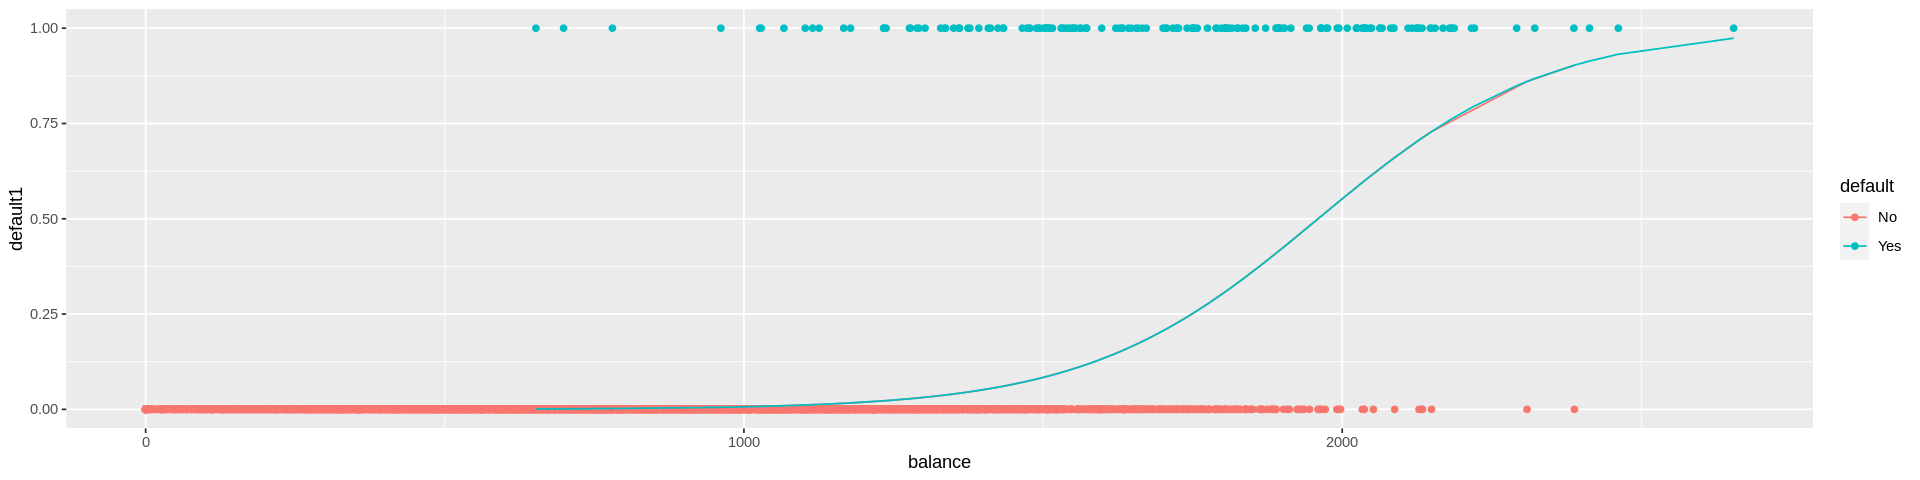

In [9]:
# Define the log-likelihood function for a binary choice model with logistic errors
# Because, by default, computers seek to minimise a function
# we maximise a function by minimising it's additive inverse
build_ll <- function(y, x) {
  ll <- function(beta) {
    p_hat <- plogis(cbind(1, x) %*% beta)
    -sum(y * log(p_hat) + (1 - y) * log(1 - p_hat))
  }
  grad <- function(beta) {
    xb <- cbind(1, x) %*% beta
    p <- 1 / (1 + exp(-xb))
    -t(cbind(1, x)) %*% (y - p)
  }
  list(ll = ll, grad = grad)
}

train <- Default[traini,]

# Estimate the model parameters using optim
start <- c(0, 0) # Initial guesses for the parameters
funcs <- build_ll(train$default1, train$balance)
result <- optim(start, fn = funcs$ll, gr = funcs$grad)

# Print the estimated parameters
cat("Estimated parameters: (", paste0(result$par, collapse = ", "), ")\n")
cat("Neg. log-likelihood: ", result$value, "\n")

yhat <- plogis(cbind(1, train$balance) %*% result$par)
p2 + geom_line(aes(y = yhat, x = balance))

In [12]:
x1x2 <- as.matrix(train[,c("balance", "income")])

start <- c(0, 0, 0) # Initial guesses for the parameters
funcs1 <- build_ll(train$default1, x1x2)
result <- optim(start, fn = funcs1$ll, gr = funcs1$grad)
b <- result$par

# Print the estimated parameters
cat("Estimated parameters: (", paste0(b, collapse = ", "), ")\n")
cat("Neg. log-likelihood: ", result$value, "\n")

yhat <- plogis(cbind(1, x1x2) %*% b)

Estimated parameters: ( -11.1437010201259, 0.0053562007038889, 2.22954252823084e-05 )
Neg. log-likelihood:  411.0685 



Now that we have two predictors $x_1$ and $x_2$ for a logistic regression, the logistic function looks like:

$$ P(Y=1 | x_1, x_2) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2})} $$

Here, the decision boundary will be the set of points $(x_1, x_2)$ for which $ P(Y=1 | x_1, x_2) = 0.5 $.

To find this boundary, you can set:

$$ \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2})} = 0.5 $$

Solving for this, you get:

$$ e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2)} = 1 $$

Taking the natural logarithm on both sides (although it's unnecessary since the exponent term equals 1), and rearranging for $x_2$, you get:

$$ x_2 = -\frac{\beta_0}{\beta_2} -\frac{\beta_1}{\beta_2} x_1 $$

This equation represents a line in the $x_1, x_2$ plane. All points on this line correspond to a probability of 0.5. Points above this line will have $ P(Y=1 | x_1, x_2) > 0.5 $ and points below this line will have $ P(Y=1 | x_1, x_2) < 0.5 $.

This linear equation is the Bayes decision boundary (BDB) in the context of a logistic regression model with two predictors.

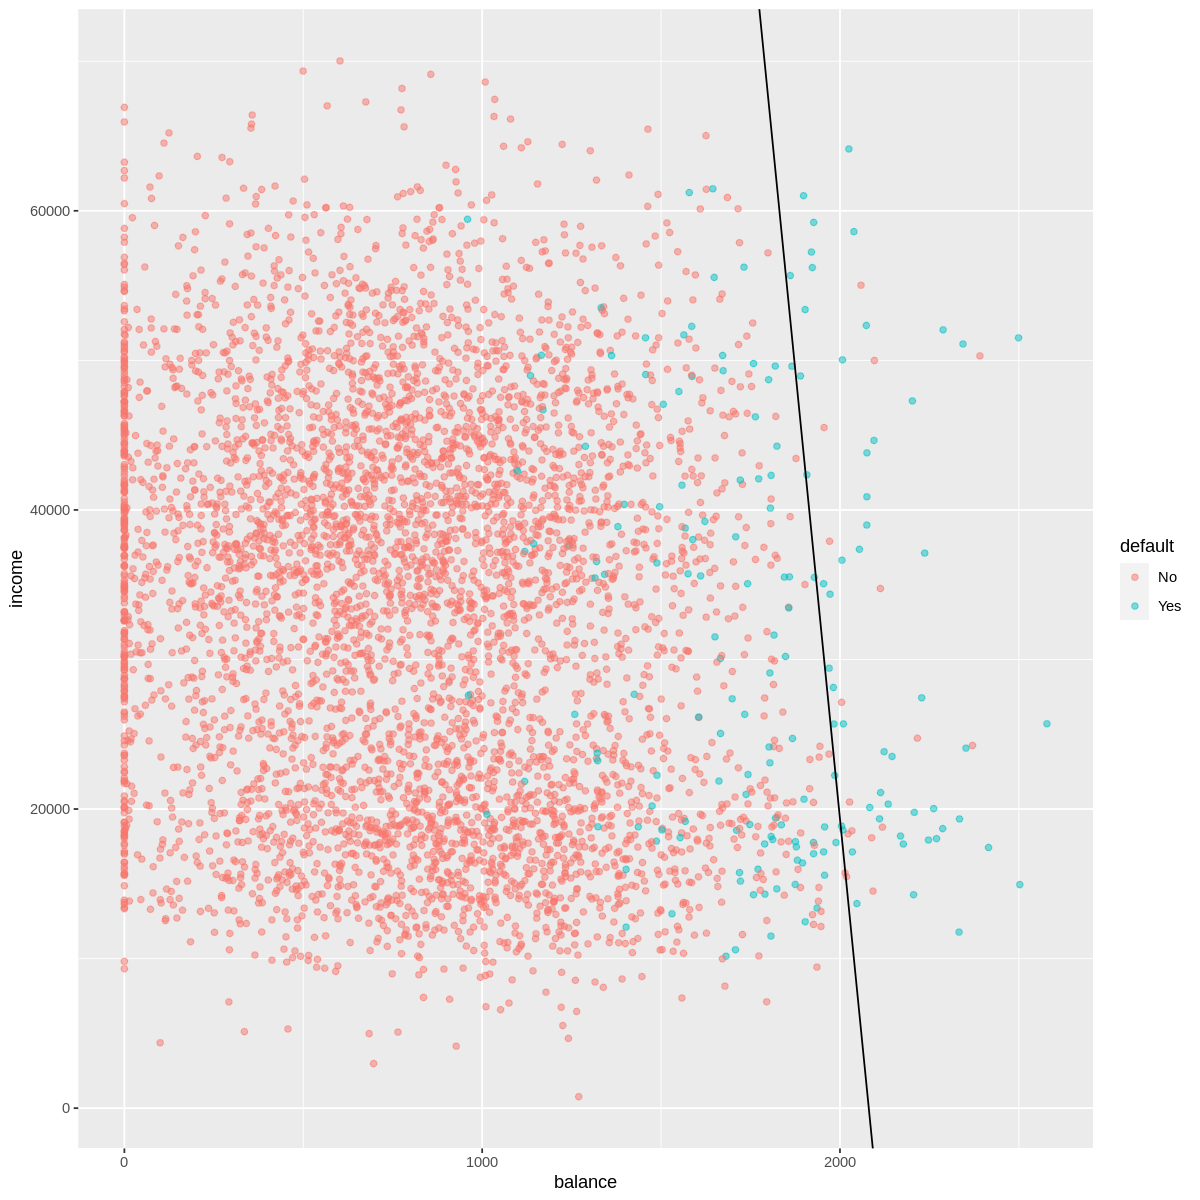

In [13]:
options(repr.plot.width = 10, repr.plot.height = 10)
p0 + geom_abline(intercept = -b[1]/b[3], slope = -b[2]/b[3])

## Interpretation
- red on the rhs (above the BDB): false positives - we predicted them to default, but they didn't
- blue on the lhs (below the BDB): false negatives - we didn't predict them to default, but they did